In [2]:
from dotenv import load_dotenv
import os
load_dotenv(dotenv_path="dev.env")

False

In [3]:
import uuid
from typing import Literal, TypedDict
from IPython.display import display, Markdown
from dotenv import load_dotenv
load_dotenv()


True

In [4]:
class EmailClassification(TypedDict):
    intent: Literal["question","bug","billing","feature"]
    urgency: Literal["low","medium","high","critical"]
    topic:str
    summary: str

class EmailAgentState(TypedDict):
    email_id: str
    email_content: str
    sender_email: str
    
    classification: EmailClassification| None

    draft_response: str | None





In [ ]:
from langchain_openai import ChatOpenAI
from langgraph.types import Command, interrupt
from langgraph.graph import END,START, StateGraph

def read_email(state: EmailAgentState) -> EmailAgentState:
    pass

llm= ChatOpenAI(model="gpt-4.1",api_key=os.getenv("OPENAI_API_KEY"))

def classify_intent(state: EmailAgentState) -> EmailAgentState:
    structured_llm=llm.with_structured_output(EmailClassification)
    classification_prompt=f"""
You are an email classification agent. Given the following email content, classify the email into one of the following intents: question, bug, billing, feature request. Also determine the urgency level (low, medium, high, critical), identify the main topic of the email, and provide a brief summary.

Email Content:
{state['email_content']}
"""
    classification=structured_llm.invoke(classification_prompt)
    return {"classification": classification}

def write_response(state: EmailAgentState)-> Command[Literal["send_reply"]]:
    """Generate a response"""
    classification=state.get("classification",{})
    context_sections=[]

    prompt=f"""
    Draft a professional response to this customer email
    Email Content:{state['email_content']}
    Email intent: {classification.get('intent'),"unknown"}
    Urgency: {classification.get('urgency',"medium")}

    """
    response=llm.invoke(prompt)
    return Command(
        update={"draft_response": response},
        goto="send_reply"
    )

def send_reply(state: EmailAgentState) -> EmailAgentState:
    print(f"Sending reply to client:{state['draft_response']}")
    return {}


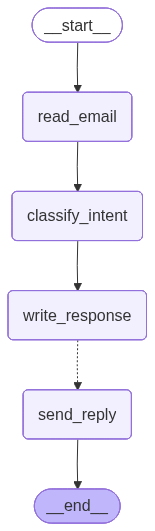

In [15]:
from IPython.display import Image,display
from langgraph.checkpoint.memory import InMemorySaver
memory = InMemorySaver()

builder=StateGraph(EmailAgentState)

builder.add_node("read_email", read_email)
builder.add_node("classify_intent", classify_intent)
builder.add_node("write_response", write_response)
builder.add_node("send_reply", send_reply)

builder.add_edge(START, "read_email")
builder.add_edge("read_email", "classify_intent")
builder.add_edge("classify_intent", "write_response")
builder.add_edge("write_response", "send_reply")
builder.add_edge("send_reply", END)

app=builder.compile(checkpointer=memory)

display(Image(app.get_graph().draw_mermaid_png()))




In [ ]:
from langgraph.checkpoint.memory import InMemorySaver

initial_state={"email_content":"I have an issue logging to SAP fiori"}
result=app.invoke(initial_state,config={"configurable": {"thread_id": "1"}})
# Access checkpoint data
print(result)